In [22]:
import networkx as nx
import sklearn
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.neighbors import kneighbors_graph
from scipy.sparse.linalg import eigsh
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.metrics import v_measure_score
from sklearn.cluster import DBSCAN
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDClassifier

k means 2D boundaries determine which cluster you belong to will be straight lines, so does that imply that the data is linearly separable?

Step1:
 - assuming we query and that cluster centers dont change, what do we find 


Step2: adding points can change outcome 
 - start with dataset, learn k means, try d+s and learn k means, how do cluster centers differ
 - empirical: real data, insert fake data, how much does cluster center move
 - theoretical: 

In [13]:
data = pd.read_csv('loc-brightkite_totalCheckins.txt', sep='\t', names=['zero', 'time', 'latitude', 'longitude', 'location id'])

In [14]:
print(data.head())
print(data.info())
print(data.describe())

   zero                  time   latitude   longitude  \
0     0  2010-10-17T01:48:53Z  39.747652 -104.992510   
1     0  2010-10-16T06:02:04Z  39.891383 -105.070814   
2     0  2010-10-16T03:48:54Z  39.891077 -105.068532   
3     0  2010-10-14T18:25:51Z  39.750469 -104.999073   
4     0  2010-10-14T00:21:47Z  39.752713 -104.996337   

                                location id  
0          88c46bf20db295831bd2d1718ad7e6f5  
1          7a0f88982aa015062b95e3b4843f9ca2  
2          dd7cd3d264c2d063832db506fba8bf79  
3  9848afcc62e500a01cf6fbf24b797732f8963683  
4          2ef143e12038c870038df53e0478cefc  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4747287 entries, 0 to 4747286
Data columns (total 5 columns):
 #   Column       Dtype  
---  ------       -----  
 0   zero         int64  
 1   time         object 
 2   latitude     float64
 3   longitude    float64
 4   location id  object 
dtypes: float64(2), int64(1), object(2)
memory usage: 181.1+ MB
None
               zero     

/Users/malachicoleman/miniconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


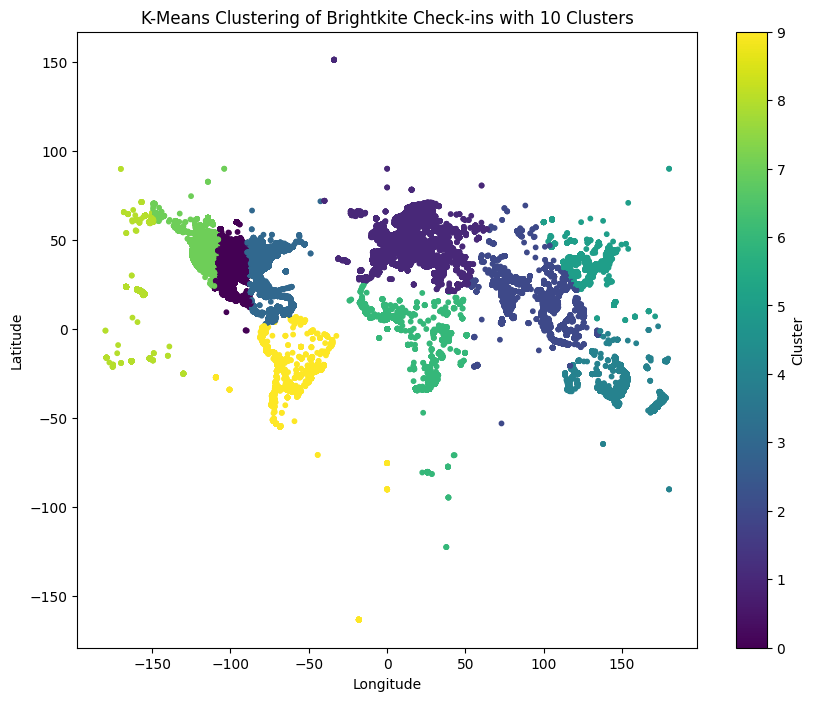

In [16]:


# Filter for relevant columns and drop any rows with missing latitude or longitude
location_data = data[['latitude', 'longitude']].dropna()

# Number of clusters - adjust based on your goal
num_clusters = 10

# Initialize and fit the K-Means model
kmeans = KMeans(n_clusters=num_clusters, random_state=0)
kmeans.fit(location_data)

# Create a new DataFrame for storing cluster labels with indices aligned to `location_data`
cluster_labels = pd.Series(kmeans.labels_, index=location_data.index)

# Add the cluster labels to the original data, aligning by index
data['cluster'] = cluster_labels.reindex(data.index).fillna(-1).astype(int)

# Plot the clusters, only plotting rows that have valid clusters
plt.figure(figsize=(10, 8))
plt.scatter(data[data['cluster'] != -1]['longitude'], data[data['cluster'] != -1]['latitude'], 
            c=data[data['cluster'] != -1]['cluster'], cmap='viridis', s=10)
plt.colorbar(label='Cluster')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title(f'K-Means Clustering of Brightkite Check-ins with {num_clusters} Clusters')
plt.show()

In [19]:
location_data['cluster'] = kmeans.labels_

# Scale data for linear regression
scaler = StandardScaler()
scaled_location_data = scaler.fit_transform(location_data[['latitude', 'longitude']])

# Train a multiclass logistic regression model
logreg = LogisticRegression(multi_class='ovr')
logreg.fit(scaled_location_data, location_data['cluster'])

# Retrieve coefficients (decision boundary equations)
coefficients = logreg.coef_
intercepts = logreg.intercept_

# Print decision boundary equations
for i, (coef, intercept) in enumerate(zip(coefficients, intercepts)):
    print(f"Equation for decision boundary for cluster {i}:")
    print(f"{coef[0]:.4f} * latitude + {coef[1]:.4f} * longitude + {intercept:.4f} = 0")

Equation for decision boundary for cluster 0:
-0.1012 * latitude + -1.7868 * longitude + -2.4627 = 0
Equation for decision boundary for cluster 1:
7.1595 * latitude + 1.5620 * longitude + -5.6018 = 0
Equation for decision boundary for cluster 2:
-0.2726 * latitude + 1.3291 * longitude + -5.0028 = 0
Equation for decision boundary for cluster 3:
0.2893 * latitude + -0.8392 * longitude + -1.1040 = 0
Equation for decision boundary for cluster 4:
-5.5850 * latitude + 28.7240 * longitude + -71.7008 = 0
Equation for decision boundary for cluster 5:
13.6521 * latitude + 60.1082 * longitude + -106.0048 = 0
Equation for decision boundary for cluster 6:
-1.5648 * latitude + -0.7510 * longitude + -3.8785 = 0
Equation for decision boundary for cluster 7:
2.4900 * latitude + -13.4547 * longitude + -11.2158 = 0
Equation for decision boundary for cluster 8:
-1.6019 * latitude + -40.0540 * longitude + -46.0262 = 0
Equation for decision boundary for cluster 9:
-4.2857 * latitude + -4.1352 * longitude + 

In [24]:
# Run K-Means clustering to get initial labels (used as "true" classes)
num_clusters = 3  # Set desired number of clusters
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=num_clusters, random_state=0)
kmeans.fit(location_data)
location_data['cluster'] = kmeans.labels_

# Prepare data for SGD-based logistic regression
scaler = StandardScaler()
location_data[['latitude', 'longitude']] = scaler.fit_transform(location_data[['latitude', 'longitude']])

# Initialize SGD-based logistic regression
sgd_logreg = SGDClassifier(loss='log_loss', max_iter=1, learning_rate='constant', eta0=0.01, tol=None, random_state=0)

# Set tolerance for convergence
tolerance = 1e-5
previous_coef = np.zeros((num_clusters, 2))
converged = False

# Iteratively sample one data point at a time and update the model
while not converged:
    # Shuffle data points and sample one point at a time
    sampled_data = location_data.sample(frac=1).reset_index(drop=True)
    
    for _, row in sampled_data.iterrows():
        # Prepare data and target
        X_sample = row[['latitude', 'longitude']].values.reshape(1, -2)
        y_sample = np.array([row['cluster']])
        
        # Update model with one sample
        sgd_logreg.partial_fit(X_sample, y_sample, classes=np.arange(num_clusters))
        
        # Check for convergence by comparing coefficients
        coef_change = np.linalg.norm(sgd_logreg.coef_ - previous_coef)
        if coef_change < tolerance:
            converged = True
            break
        
        # Update previous coefficients for the next comparison
        previous_coef = sgd_logreg.coef_.copy()

# Output the final decision boundary equations
for i, (coef, intercept) in enumerate(zip(sgd_logreg.coef_, sgd_logreg.intercept_)):
    print(f"Equation for decision boundary for cluster {i}:")
    print(f"{coef[0]:.4f} * latitude + {coef[1]:.4f} * longitude + {intercept:.4f} = 0")

/Users/malachicoleman/miniconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Equation for decision boundary for cluster 0:
0.7055 * latitude + -5.9972 * longitude + 0.2528 = 0
Equation for decision boundary for cluster 1:
-3.3188 * latitude + 0.4804 * longitude + -4.2421 = 0
Equation for decision boundary for cluster 2:
3.2168 * latitude + 4.0365 * longitude + -2.4638 = 0


do this with graphs at each x interations to see how decision boundaries converge 

k means with adding points to change environment

sample uniformly, do SGD, how good is that? Next, can this motivate how labels are changing and the heuristic for picking points 

active learning, voronoi diagrams 

theoretical yields. multiclass classification. rates of convergence etcetera. 

every query, rerun k means.... noisy labels? how do we query points, how do decide the number of points to query, active learning 

set nuber of query points. can move them around at each step, only allowed to move them by a given amount. Where do you move them? Send points towards different decision boundaries 

OR: we can put points where we want every single but, but k means is retrained on gaussians centererd at original data points. so our underlying data is shifting,,, how do we deal with this? we want some relationship between how many poionts we add at each step and how noisy things get  